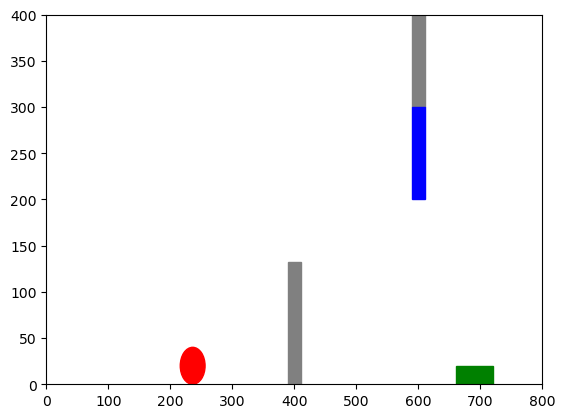

In [2]:
import gym
from gym import spaces
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# Constants
SCREEN_WIDTH = 800
SCREEN_HEIGHT = 400
BAR_WIDTH = 20
BAR_HEIGHT = 100
BALL_RADIUS = 20
BASKET_WIDTH = 60
BASKET_HEIGHT = 20
MOVEMENT_SPEED = 5
VELOCITY = 10

class BallSortCraneEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(BallSortCraneEnv, self).__init__()

        # Define action and observation space
        self.action_space = spaces.Discrete(5)
        self.observation_space = spaces.Box(low=0, high=max(SCREEN_WIDTH, SCREEN_HEIGHT), shape=(6,), dtype=np.float32)

        # Initialize game variables
        self.bar_x = SCREEN_WIDTH - (SCREEN_WIDTH // 4)
        self.bar_y = SCREEN_HEIGHT - (SCREEN_HEIGHT // 4)
        self.bar_height = BAR_HEIGHT
        self.extend_bar = False
        self.shrink_bar = False
        self.move_left = False
        self.move_right = False
        self.score = 0
        self.is_grabbing = False
        self.previous_distance_to_ball = float('inf')
        self.previous_distance_to_basket = float('inf')
        self.ball_x, self.ball_y, self.basket_x, self.basket_y, self.pillar_height = self.randomize_positions()
        self.figure, self.ax = plt.subplots()
        self.current_step = 0
        self.initial_bar_height = BAR_HEIGHT
        self.was_holding_ball = False
        
    def randomize_positions(self):
        ball_x = random.randint(BALL_RADIUS, SCREEN_WIDTH // 2 - BALL_RADIUS)
        basket_x = random.randint(SCREEN_WIDTH // 2 + BASKET_WIDTH // 2, SCREEN_WIDTH - BASKET_WIDTH // 2)
        max_pillar_height = SCREEN_HEIGHT // 2
        pillar_height = random.randint(50, max_pillar_height)
        ball_y = BALL_RADIUS
        basket_y = BASKET_HEIGHT // 2
        return ball_x, ball_y, basket_x, basket_y, pillar_height
    
    def is_better_position_for_grabbing(self):
        # Check if the bar is getting closer to the ball
        current_distance_to_ball = np.linalg.norm([self.ball_x - self.bar_x, self.ball_y - (self.bar_y - self.bar_height)])
        is_getting_closer = current_distance_to_ball < self.previous_distance_to_ball
        
        # Check if extending the bar is beneficial for grabbing the ball
        is_correct_extension = self.extend_bar and self.bar_y - self.bar_height > self.ball_y

        return is_getting_closer or is_correct_extension

    def is_better_position_for_releasing(self):
        # Check if the bar (with the ball) is getting closer to the basket
        current_distance_to_basket = np.linalg.norm([self.basket_x - self.bar_x, self.basket_y - (self.bar_y - self.bar_height)])
        is_getting_closer = current_distance_to_basket < self.previous_distance_to_basket

        # Check if retracting the bar is beneficial for releasing the ball
        # This can be a simple condition based on the bar's position relative to the basket.
        is_correct_retraction = self.shrink_bar and self.ball_x == self.bar_x and self.bar_y - self.bar_height < self.basket_y

        return is_getting_closer or is_correct_retraction
    
    def step(self, action):
        # Handle actions
        if action == 0:  # Move Left
            self.move_left = True
            self.move_right = False
        elif action == 1:  # Move Right
            self.move_left = False
            self.move_right = True
        elif action == 2:  # Extend Bar
            self.extend_bar = True
            self.shrink_bar = False
        elif action == 3:  # Shrink Bar
            self.extend_bar = False
            self.shrink_bar = True
        elif action == 4:  # Grab/Release
            self.is_grabbing = not self.is_grabbing

        # Update the was_holding_ball status
        if action == 4:  # Grab/Release action
            self.was_holding_ball = self.is_grabbing

        # Update game state
        self.update_game_state()

        # Calculate reward, check if game is done
        reward = self.calculate_reward()
        done = self.is_game_done()

        # Observation
        obs = np.array([self.ball_x, self.ball_y, self.bar_x, self.bar_y, self.basket_x, self.basket_y], dtype=np.float32)

        # Update the previous distances after updating the game state
        self.previous_distance_to_ball = np.linalg.norm([self.ball_x - self.bar_x, self.ball_y - (self.bar_y - self.bar_height)])
        self.previous_distance_to_basket = np.linalg.norm([self.basket_x - self.bar_x, self.basket_y - (self.bar_y - self.bar_height)])

        # Increment step count
        self.current_step += 1

        return obs, reward, done, {}



    def reset(self):
        self.current_step = 0
        self.bar_x, self.bar_y, self.bar_height = SCREEN_WIDTH - (SCREEN_WIDTH // 4), SCREEN_HEIGHT - (SCREEN_HEIGHT // 4), BAR_HEIGHT
        self.extend_bar, self.shrink_bar, self.move_left, self.move_right, self.is_grabbing = False, False, False, False, False
        self.score = 0
        self.previous_distance_to_ball = float('inf')
        self.previous_distance_to_basket = float('inf')
        self.ball_x, self.ball_y, self.basket_x, self.basket_y, self.pillar_height = self.randomize_positions()
        self.initial_bar_height = self.bar_height
        return np.array([self.ball_x, self.ball_y, self.bar_x, self.bar_y, self.basket_x, self.basket_y], dtype=np.float32)
    

    def render(self, mode='human'):
        
        self.ax.clear()
        self.ax.set_xlim(0, SCREEN_WIDTH)
        self.ax.set_ylim(0, SCREEN_HEIGHT)

        # Draw the pillar in the middle of the screen
        pillar_x = SCREEN_WIDTH // 2
        pillar = patches.Rectangle((pillar_x - 10, 0), 20, self.pillar_height, color='gray')
        self.ax.add_patch(pillar)

        # Draw the crane's arm and bar
        crane_base_x = self.bar_x
        crane_base_y = SCREEN_HEIGHT
        crane_arm_length = SCREEN_HEIGHT - self.bar_y + self.bar_height
        crane_arm = patches.Rectangle((crane_base_x - BAR_WIDTH/2, self.bar_y), BAR_WIDTH, crane_arm_length, color='gray')
        self.ax.add_patch(crane_arm)
        bar = patches.Rectangle((self.bar_x - BAR_WIDTH/2, self.bar_y - self.bar_height), BAR_WIDTH, self.bar_height, color='blue')
        self.ax.add_patch(bar)

        # Draw the ball
        ball = patches.Circle((self.ball_x, self.ball_y), BALL_RADIUS, color='red')
        self.ax.add_patch(ball)

        # Draw the basket
        basket = patches.Rectangle((self.basket_x - BASKET_WIDTH/2, self.basket_y - BASKET_HEIGHT/2), BASKET_WIDTH, BASKET_HEIGHT, color='green')
        self.ax.add_patch(basket)
        
        if mode == 'rgb_array':
            # Convert the plot to an RGB array
            self.figure.canvas.draw()
            width, height = self.figure.get_size_inches() * self.figure.get_dpi()
            image = np.frombuffer(self.figure.canvas.tostring_rgb(), dtype='uint8')
            image = image.reshape(int(height), int(width), 3)
            return image
        elif mode == 'human':
            # [Existing code for human rendering]
            plt.draw()
            plt.pause(0.01)

    def close(self):
        plt.close(self.figure)

    def update_game_state(self):
        # Update bar position
        if self.move_left:
            self.bar_x = max(self.bar_x - MOVEMENT_SPEED, BAR_WIDTH / 2)
        if self.move_right:
            self.bar_x = min(self.bar_x + MOVEMENT_SPEED, SCREEN_WIDTH - BAR_WIDTH / 2)

        # Update bar height
        if self.extend_bar and self.bar_height < SCREEN_HEIGHT - self.bar_y:
            self.bar_height += 10
        if self.shrink_bar and self.bar_height > 10:
            self.bar_height -= 10

        # Handle ball grabbing logic
        if self.is_grabbing:
            # Check if the bar is above the ball
            if self.bar_x - BAR_WIDTH / 2 < self.ball_x < self.bar_x + BAR_WIDTH / 2 and \
               self.ball_y < self.bar_y - self.bar_height + BALL_RADIUS:
                self.ball_x = self.bar_x
                self.ball_y = self.bar_y - self.bar_height + BALL_RADIUS
        else:
            # Ball falls due to gravity
            if self.ball_y > BALL_RADIUS:
                self.ball_y -= VELOCITY
            else:
                self.ball_y = BALL_RADIUS  # Ensure ball doesn't go below the ground
                
    def is_directly_above_basket(self):
            # Define a threshold for being considered 'directly above'
            threshold = 10  # Adjust this value as needed

            # Check if the bar's horizontal position is close enough to the basket's position
            return abs(self.bar_x - self.basket_x) < threshold and self.bar_y - self.bar_height < self.basket_y + BASKET_HEIGHT / 2        
        
    def is_ball_in_basket(self):
        # Check if the ball is within the horizontal boundaries of the basket
        ball_in_basket_horizontally = (self.ball_x + BALL_RADIUS > self.basket_x - BASKET_WIDTH / 2) and \
                                      (self.ball_x - BALL_RADIUS < self.basket_x + BASKET_WIDTH / 2)

        # Check if the ball is within the vertical boundaries of the basket
        ball_in_basket_vertically = (self.ball_y - BALL_RADIUS < self.basket_y + BASKET_HEIGHT / 2) and \
                                    (self.ball_y + BALL_RADIUS > self.basket_y - BASKET_HEIGHT / 2)

        # The ball is in the basket if it's within both horizontal and vertical boundaries
        return ball_in_basket_horizontally and ball_in_basket_vertically
    def is_directly_above_ball(self):
            # Define a threshold for being considered 'directly above'
            threshold = 10  # Adjust this value as needed

            # Check if the bar's horizontal position is close enough to the ball's position
            return abs(self.bar_x - self.ball_x) < threshold and self.ball_y < self.bar_y - self.bar_height
        
    def calculate_reward(self):
        # Initialize reward
        action_penalty = -0.05
        reward = 0
        reward += action_penalty
        # Calculate the distance to the ball and to the basket
        distance_to_ball = np.linalg.norm([self.ball_x - self.bar_x, self.ball_y - (self.bar_y - self.bar_height)])
        distance_to_basket = np.linalg.norm([self.basket_x - self.bar_x, self.basket_y - (self.bar_y - self.bar_height)])

        # Reward/Penalty for moving closer/away from the ball
        if distance_to_ball < self.previous_distance_to_ball:
            reward += 1
        else:
            reward -= 1

        return reward



    def is_game_done(self):
        max_score = 50
        max_steps = 1000
        ball_in_basket = self.is_ball_in_basket()
        return self.score >= max_score or self.current_step >= max_steps or ball_in_basket


# Create and test your environment
env = BallSortCraneEnv()
env.reset()
env.render()

C:\Users\Kevin\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16, 16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 1/5000000, Total Reward: 9.499999999999991
Episode: 2/5000000, Total Reward: -4.500000000000002
Episode: 3/5000000, Total Reward: -8.500000000000002
Episode: 4/5000000, Total Reward: -24.500000000000018
Episode: 5/5000000, Total Reward: -12.500000000000014
Episode: 6/5000000, Total Reward: 3.4999999999999947
Episode: 7/5000000, Total Reward: -2.4999999999999973
Episode: 8/5000000, Total Reward: -0.4999999999999978
Episode: 9/5000000, Total Reward: -10.499999999999998
Episode: 10/5000000, Total Reward: -14.500000000000021
Episode: 11/5000000, Total Reward: 7.5000000000000036
Episode: 12/5000000, Total Reward: 1.5000000000000018
Episode: 13/5000000, Total Reward: -8.500000000000018
Episode: 14/5000000, Total Reward: -2.5000000000000147
Episode: 15/5000000, Total Reward: -8.500000000000005
Episode: 16/5000000, Total Reward: -24.50000000000001
Episode: 17/5000000, Total Reward: -2.499999999999999
Episode: 18/5000000, Total Reward: -6.4999999999999964
Episode: 19/5000000, Total Rew

Episode: 155/5000000, Total Reward: -14.500000000000021
Episode: 156/5000000, Total Reward: 11.499999999999986
Episode: 157/5000000, Total Reward: 3.4999999999999982
Episode: 158/5000000, Total Reward: -6.5
Episode: 159/5000000, Total Reward: -6.499999999999995
Episode: 160/5000000, Total Reward: -2.4999999999999964
Episode: 161/5000000, Total Reward: 1.5000000000000007
Episode: 162/5000000, Total Reward: 19.49999999999997
Episode: 163/5000000, Total Reward: 3.4999999999999867
Episode: 164/5000000, Total Reward: 17.499999999999975
Episode: 165/5000000, Total Reward: 17.499999999999993
Episode: 166/5000000, Total Reward: 9.500000000000004
Episode: 167/5000000, Total Reward: 7.4999999999999885
Episode: 168/5000000, Total Reward: -8.500000000000004
Episode: 169/5000000, Total Reward: -14.50000000000001
Episode: 170/5000000, Total Reward: -4.4999999999999964
Episode: 171/5000000, Total Reward: 1.5000000000000033
Episode: 172/5000000, Total Reward: -20.500000000000007
Episode: 173/5000000, 

Episode: 305/5000000, Total Reward: 37.5
Episode: 306/5000000, Total Reward: -14.500000000000028
Episode: 307/5000000, Total Reward: 29.49999999999997
Episode: 308/5000000, Total Reward: -0.4999999999999982
Episode: 309/5000000, Total Reward: 33.49999999999998
Episode: 310/5000000, Total Reward: 39.50000000000002
Episode: 311/5000000, Total Reward: 35.499999999999986
Episode: 312/5000000, Total Reward: 19.49999999999999
Episode: 313/5000000, Total Reward: 3.4999999999999893
Episode: 314/5000000, Total Reward: 13.499999999999982
Episode: 315/5000000, Total Reward: 13.499999999999973
Episode: 316/5000000, Total Reward: 9.499999999999982
Episode: 317/5000000, Total Reward: -6.499999999999998
Episode: 318/5000000, Total Reward: 29.499999999999975
Episode: 319/5000000, Total Reward: 23.49999999999999
Episode: 320/5000000, Total Reward: -32.50000000000003
Episode: 321/5000000, Total Reward: 7.499999999999986
Episode: 322/5000000, Total Reward: 27.499999999999975
Episode: 323/5000000, Total R

Episode: 455/5000000, Total Reward: 29.499999999999986
Episode: 456/5000000, Total Reward: 43.500000000000014
Episode: 457/5000000, Total Reward: 35.499999999999986
Episode: 458/5000000, Total Reward: 23.49999999999997
Episode: 459/5000000, Total Reward: -8.500000000000005
Episode: 460/5000000, Total Reward: 21.499999999999993
Episode: 461/5000000, Total Reward: 37.49999999999999
Episode: 462/5000000, Total Reward: 29.500000000000018
Episode: 463/5000000, Total Reward: 37.49999999999999
Episode: 464/5000000, Total Reward: 39.50000000000003
Episode: 465/5000000, Total Reward: 9.499999999999988
Episode: 466/5000000, Total Reward: -2.500000000000013
Episode: 467/5000000, Total Reward: 29.49999999999998
Episode: 468/5000000, Total Reward: 33.499999999999986
Episode: 469/5000000, Total Reward: 37.50000000000003
Episode: 470/5000000, Total Reward: 33.49999999999998
Episode: 471/5000000, Total Reward: 19.499999999999986
Episode: 472/5000000, Total Reward: 37.50000000000003
Episode: 473/500000

Episode: 606/5000000, Total Reward: 47.50000000000003
Episode: 607/5000000, Total Reward: 27.499999999999975
Episode: 608/5000000, Total Reward: 29.49999999999998
Episode: 609/5000000, Total Reward: -50.499999999999964
Episode: 610/5000000, Total Reward: 27.499999999999986
Episode: 611/5000000, Total Reward: -8.500000000000023
Episode: 612/5000000, Total Reward: -38.499999999999964
Episode: 613/5000000, Total Reward: 31.499999999999975
Episode: 614/5000000, Total Reward: 41.50000000000003
Episode: 615/5000000, Total Reward: -50.499999999999964
Episode: 616/5000000, Total Reward: 47.50000000000003
Episode: 617/5000000, Total Reward: 19.499999999999986
Episode: 618/5000000, Total Reward: 41.50000000000001
Episode: 619/5000000, Total Reward: 19.49999999999997
Episode: 620/5000000, Total Reward: -14.500000000000028
Episode: 621/5000000, Total Reward: 17.499999999999982
Episode: 622/5000000, Total Reward: 47.50000000000003
Episode: 623/5000000, Total Reward: 43.500000000000014
Episode: 624/

Episode: 757/5000000, Total Reward: 23.49999999999997
Episode: 758/5000000, Total Reward: -50.499999999999964
Episode: 759/5000000, Total Reward: -50.499999999999964
Episode: 760/5000000, Total Reward: 27.49999999999997
Episode: 761/5000000, Total Reward: 35.499999999999986
Episode: 762/5000000, Total Reward: 33.49999999999998
Episode: 763/5000000, Total Reward: 17.49999999999998
Episode: 764/5000000, Total Reward: -2.500000000000002
Episode: 765/5000000, Total Reward: 35.499999999999986
Episode: 766/5000000, Total Reward: -50.499999999999964
Episode: 767/5000000, Total Reward: 47.50000000000003
Episode: 768/5000000, Total Reward: -18.500000000000018
Episode: 769/5000000, Total Reward: -50.499999999999964
Episode: 770/5000000, Total Reward: 13.499999999999984
Episode: 771/5000000, Total Reward: 11.49999999999998
Episode: 772/5000000, Total Reward: 13.499999999999972
Episode: 773/5000000, Total Reward: 3.500000000000008
Episode: 774/5000000, Total Reward: 29.49999999999998
Episode: 775/

Episode: 907/5000000, Total Reward: -50.499999999999964
Episode: 908/5000000, Total Reward: 45.50000000000003
Episode: 909/5000000, Total Reward: 23.49999999999997
Episode: 910/5000000, Total Reward: 37.50000000000003
Episode: 911/5000000, Total Reward: -0.4999999999999969
Episode: 912/5000000, Total Reward: 37.49999999999999
Episode: 913/5000000, Total Reward: -50.499999999999964
Episode: 914/5000000, Total Reward: 39.5
Episode: 915/5000000, Total Reward: 47.50000000000003
Episode: 916/5000000, Total Reward: -50.499999999999964
Episode: 917/5000000, Total Reward: 47.50000000000003
Episode: 918/5000000, Total Reward: 29.49999999999997
Episode: 919/5000000, Total Reward: 47.50000000000003
Episode: 920/5000000, Total Reward: -2.500000000000002
Episode: 921/5000000, Total Reward: 33.49999999999998
Episode: 922/5000000, Total Reward: -6.499999999999992
Episode: 923/5000000, Total Reward: 35.499999999999986
Episode: 924/5000000, Total Reward: 23.499999999999975
Episode: 925/5000000, Total R

Episode: 1058/5000000, Total Reward: 29.49999999999997
Episode: 1059/5000000, Total Reward: -50.499999999999964
Episode: 1060/5000000, Total Reward: 47.50000000000003
Episode: 1061/5000000, Total Reward: -50.499999999999964
Episode: 1062/5000000, Total Reward: 43.50000000000002
Episode: 1063/5000000, Total Reward: -50.499999999999964
Episode: 1064/5000000, Total Reward: 29.49999999999997
Episode: 1065/5000000, Total Reward: -0.5000000000000022
Episode: 1066/5000000, Total Reward: 29.49999999999997
Episode: 1067/5000000, Total Reward: 3.500000000000008
Episode: 1068/5000000, Total Reward: 39.5
Episode: 1069/5000000, Total Reward: -50.499999999999964
Episode: 1070/5000000, Total Reward: -2.500000000000002
Episode: 1071/5000000, Total Reward: -50.499999999999964
Episode: 1072/5000000, Total Reward: -14.500000000000028
Episode: 1073/5000000, Total Reward: -50.499999999999964
Episode: 1074/5000000, Total Reward: -2.5
Episode: 1075/5000000, Total Reward: 33.49999999999998
Episode: 1076/50000

Episode: 1206/5000000, Total Reward: -0.5000000000000022
Episode: 1207/5000000, Total Reward: -50.499999999999964
Episode: 1208/5000000, Total Reward: 35.499999999999986
Episode: 1209/5000000, Total Reward: -4.4999999999999964
Episode: 1210/5000000, Total Reward: 33.499999999999986
Episode: 1211/5000000, Total Reward: 5.500000000000008
Episode: 1212/5000000, Total Reward: -50.499999999999964
Episode: 1213/5000000, Total Reward: -8.499999999999993
Episode: 1214/5000000, Total Reward: -10.500000000000028
Episode: 1215/5000000, Total Reward: 47.50000000000003
Episode: 1216/5000000, Total Reward: -50.499999999999964
Episode: 1217/5000000, Total Reward: -10.5
Episode: 1218/5000000, Total Reward: 35.499999999999986
Episode: 1219/5000000, Total Reward: 37.49999999999999
Episode: 1220/5000000, Total Reward: -50.499999999999964
Episode: 1221/5000000, Total Reward: 17.49999999999997
Episode: 1222/5000000, Total Reward: 47.50000000000003
Episode: 1223/5000000, Total Reward: 3.499999999999999
Epis

Episode: 1354/5000000, Total Reward: 19.499999999999986
Episode: 1355/5000000, Total Reward: -50.499999999999964
Episode: 1356/5000000, Total Reward: -50.499999999999964
Episode: 1357/5000000, Total Reward: -14.500000000000016
Episode: 1358/5000000, Total Reward: 37.50000000000003
Episode: 1359/5000000, Total Reward: 47.50000000000003
Episode: 1360/5000000, Total Reward: 37.49999999999999
Episode: 1361/5000000, Total Reward: -22.500000000000004
Episode: 1362/5000000, Total Reward: -50.499999999999964
Episode: 1363/5000000, Total Reward: 31.49999999999998
Episode: 1364/5000000, Total Reward: 27.499999999999986
Episode: 1365/5000000, Total Reward: 33.49999999999998
Episode: 1366/5000000, Total Reward: 29.49999999999997
Episode: 1367/5000000, Total Reward: 35.499999999999986
Episode: 1368/5000000, Total Reward: -14.500000000000028
Episode: 1369/5000000, Total Reward: 3.500000000000008
Episode: 1370/5000000, Total Reward: 33.49999999999998
Episode: 1371/5000000, Total Reward: 29.4999999999

Episode: 1502/5000000, Total Reward: 35.499999999999986
Episode: 1503/5000000, Total Reward: 19.49999999999997
Episode: 1504/5000000, Total Reward: -50.499999999999964
Episode: 1505/5000000, Total Reward: 5.500000000000008
Episode: 1506/5000000, Total Reward: -16.50000000000003
Episode: 1507/5000000, Total Reward: 1.500000000000006
Episode: 1508/5000000, Total Reward: -50.499999999999964
Episode: 1509/5000000, Total Reward: 33.49999999999998
Episode: 1510/5000000, Total Reward: 47.50000000000003
Episode: 1511/5000000, Total Reward: 27.49999999999998
Episode: 1512/5000000, Total Reward: 29.49999999999997
Episode: 1513/5000000, Total Reward: 33.50000000000003
Episode: 1514/5000000, Total Reward: 47.50000000000003
Episode: 1515/5000000, Total Reward: 3.500000000000008
Episode: 1516/5000000, Total Reward: -16.500000000000018
Episode: 1517/5000000, Total Reward: 47.50000000000003
Episode: 1518/5000000, Total Reward: 15.499999999999972
Episode: 1519/5000000, Total Reward: -50.499999999999964

Episode: 1651/5000000, Total Reward: -8.500000000000016
Episode: 1652/5000000, Total Reward: 45.50000000000003
Episode: 1653/5000000, Total Reward: 35.499999999999986
Episode: 1654/5000000, Total Reward: 13.499999999999972
Episode: 1655/5000000, Total Reward: 47.50000000000003
Episode: 1656/5000000, Total Reward: -16.50000000000003
Episode: 1657/5000000, Total Reward: -50.499999999999964
Episode: 1658/5000000, Total Reward: 37.49999999999999
Episode: 1659/5000000, Total Reward: 33.49999999999998
Episode: 1660/5000000, Total Reward: 21.49999999999997
Episode: 1661/5000000, Total Reward: 47.50000000000003
Episode: 1662/5000000, Total Reward: 29.49999999999997
Episode: 1663/5000000, Total Reward: 5.500000000000008
Episode: 1664/5000000, Total Reward: 29.49999999999997
Episode: 1665/5000000, Total Reward: 47.50000000000003
Episode: 1666/5000000, Total Reward: -16.500000000000018
Episode: 1667/5000000, Total Reward: 47.50000000000003
Episode: 1668/5000000, Total Reward: 29.49999999999998
Ep

Episode: 1800/5000000, Total Reward: -0.5000000000000022
Saved model at episode 1800
Episode: 1801/5000000, Total Reward: 47.50000000000003
Episode: 1802/5000000, Total Reward: 29.499999999999986
Episode: 1803/5000000, Total Reward: 31.49999999999997
Episode: 1804/5000000, Total Reward: 19.49999999999997
Episode: 1805/5000000, Total Reward: 35.499999999999986
Episode: 1806/5000000, Total Reward: 19.49999999999997
Episode: 1807/5000000, Total Reward: 9.499999999999972
Episode: 1808/5000000, Total Reward: 47.50000000000003
Episode: 1809/5000000, Total Reward: -50.499999999999964
Episode: 1810/5000000, Total Reward: 29.499999999999986
Episode: 1811/5000000, Total Reward: 35.499999999999986
Episode: 1812/5000000, Total Reward: 39.5
Episode: 1813/5000000, Total Reward: -50.499999999999964
Episode: 1814/5000000, Total Reward: -14.500000000000018
Episode: 1815/5000000, Total Reward: 45.50000000000002
Episode: 1816/5000000, Total Reward: 27.50000000000001
Episode: 1817/5000000, Total Reward: -

Episode: 1948/5000000, Total Reward: -50.499999999999964
Episode: 1949/5000000, Total Reward: -2.500000000000002
Episode: 1950/5000000, Total Reward: 39.5
Episode: 1951/5000000, Total Reward: 41.50000000000001
Episode: 1952/5000000, Total Reward: 29.49999999999997
Episode: 1953/5000000, Total Reward: 47.50000000000003
Episode: 1954/5000000, Total Reward: 35.499999999999986
Episode: 1955/5000000, Total Reward: 35.50000000000003
Episode: 1956/5000000, Total Reward: 21.49999999999999
Episode: 1957/5000000, Total Reward: 47.50000000000003
Episode: 1958/5000000, Total Reward: 35.499999999999986
Episode: 1959/5000000, Total Reward: -14.500000000000028
Episode: 1960/5000000, Total Reward: -6.500000000000011
Episode: 1961/5000000, Total Reward: -2.500000000000002
Episode: 1962/5000000, Total Reward: 47.50000000000003
Episode: 1963/5000000, Total Reward: 29.499999999999982
Episode: 1964/5000000, Total Reward: 47.50000000000003
Episode: 1965/5000000, Total Reward: -50.499999999999964
Episode: 19

Episode: 2096/5000000, Total Reward: 33.49999999999998
Episode: 2097/5000000, Total Reward: -18.500000000000018
Episode: 2098/5000000, Total Reward: 29.49999999999997
Episode: 2099/5000000, Total Reward: 29.49999999999997
Episode: 2100/5000000, Total Reward: 47.50000000000003
Saved model at episode 2100
Episode: 2101/5000000, Total Reward: 45.50000000000002
Episode: 2102/5000000, Total Reward: -0.499999999999998
Episode: 2103/5000000, Total Reward: 29.499999999999986
Episode: 2104/5000000, Total Reward: -14.500000000000028
Episode: 2105/5000000, Total Reward: 7.500000000000004
Episode: 2106/5000000, Total Reward: 47.50000000000003
Episode: 2107/5000000, Total Reward: 47.50000000000003
Episode: 2108/5000000, Total Reward: 41.50000000000002
Episode: 2109/5000000, Total Reward: -40.499999999999964
Episode: 2110/5000000, Total Reward: 47.50000000000003
Episode: 2111/5000000, Total Reward: -2.500000000000002
Episode: 2112/5000000, Total Reward: 33.49999999999998
Episode: 2113/5000000, Total

Episode: 2244/5000000, Total Reward: -4.499999999999994
Episode: 2245/5000000, Total Reward: -50.499999999999964
Episode: 2246/5000000, Total Reward: 43.500000000000014
Episode: 2247/5000000, Total Reward: 31.49999999999997
Episode: 2248/5000000, Total Reward: 17.49999999999997
Episode: 2249/5000000, Total Reward: 29.49999999999997
Episode: 2250/5000000, Total Reward: -50.499999999999964
Episode: 2251/5000000, Total Reward: 31.49999999999997
Episode: 2252/5000000, Total Reward: -50.499999999999964
Episode: 2253/5000000, Total Reward: 35.499999999999986
Episode: 2254/5000000, Total Reward: -50.499999999999964
Episode: 2255/5000000, Total Reward: 47.50000000000003
Episode: 2256/5000000, Total Reward: 47.50000000000003
Episode: 2257/5000000, Total Reward: -50.499999999999964
Episode: 2258/5000000, Total Reward: 41.50000000000003
Episode: 2259/5000000, Total Reward: 35.499999999999986
Episode: 2260/5000000, Total Reward: 41.50000000000001
Episode: 2261/5000000, Total Reward: -4.49999999999

Episode: 2392/5000000, Total Reward: 33.499999999999986
Episode: 2393/5000000, Total Reward: 27.49999999999998
Episode: 2394/5000000, Total Reward: -50.499999999999964
Episode: 2395/5000000, Total Reward: 45.50000000000003
Episode: 2396/5000000, Total Reward: 45.50000000000002
Episode: 2397/5000000, Total Reward: 47.50000000000003
Episode: 2398/5000000, Total Reward: -50.499999999999964
Episode: 2399/5000000, Total Reward: 29.499999999999986
Episode: 2400/5000000, Total Reward: -14.500000000000018
Saved model at episode 2400
Episode: 2401/5000000, Total Reward: 29.499999999999986
Episode: 2402/5000000, Total Reward: -50.499999999999964
Episode: 2403/5000000, Total Reward: 41.50000000000001
Episode: 2404/5000000, Total Reward: 31.49999999999997
Episode: 2405/5000000, Total Reward: -2.500000000000002
Episode: 2406/5000000, Total Reward: 33.499999999999986
Episode: 2407/5000000, Total Reward: 19.499999999999982
Episode: 2408/5000000, Total Reward: -34.49999999999998
Episode: 2409/5000000,

Episode: 2540/5000000, Total Reward: 29.49999999999998
Episode: 2541/5000000, Total Reward: 33.49999999999998
Episode: 2542/5000000, Total Reward: 35.50000000000003
Episode: 2543/5000000, Total Reward: -50.499999999999964
Episode: 2544/5000000, Total Reward: 47.50000000000003
Episode: 2545/5000000, Total Reward: 37.49999999999999
Episode: 2546/5000000, Total Reward: -50.499999999999964
Episode: 2547/5000000, Total Reward: 33.49999999999999
Episode: 2548/5000000, Total Reward: -10.50000000000002
Episode: 2549/5000000, Total Reward: -2.500000000000002
Episode: 2550/5000000, Total Reward: -2.500000000000002
Episode: 2551/5000000, Total Reward: -10.500000000000028
Episode: 2552/5000000, Total Reward: 5.500000000000008
Episode: 2553/5000000, Total Reward: -50.499999999999964
Episode: 2554/5000000, Total Reward: 5.500000000000008
Episode: 2555/5000000, Total Reward: 23.49999999999997
Episode: 2556/5000000, Total Reward: 33.49999999999999
Episode: 2557/5000000, Total Reward: 45.50000000000002

Episode: 2688/5000000, Total Reward: 45.50000000000003
Episode: 2689/5000000, Total Reward: 31.499999999999975
Episode: 2690/5000000, Total Reward: -50.499999999999964
Episode: 2691/5000000, Total Reward: 37.49999999999999
Episode: 2692/5000000, Total Reward: 11.499999999999972
Episode: 2693/5000000, Total Reward: 45.50000000000002
Episode: 2694/5000000, Total Reward: -50.499999999999964
Episode: 2695/5000000, Total Reward: 19.49999999999997
Episode: 2696/5000000, Total Reward: -10.500000000000021
Episode: 2697/5000000, Total Reward: -50.499999999999964
Episode: 2698/5000000, Total Reward: -50.499999999999964
Episode: 2699/5000000, Total Reward: 47.50000000000003
Episode: 2700/5000000, Total Reward: 29.499999999999982
Saved model at episode 2700
Episode: 2701/5000000, Total Reward: 37.49999999999999
Episode: 2702/5000000, Total Reward: 47.50000000000003
Episode: 2703/5000000, Total Reward: 23.49999999999997
Episode: 2704/5000000, Total Reward: 31.49999999999997
Episode: 2705/5000000, T

Episode: 2836/5000000, Total Reward: 45.50000000000003
Episode: 2837/5000000, Total Reward: 31.49999999999997
Episode: 2838/5000000, Total Reward: 41.50000000000003
Episode: 2839/5000000, Total Reward: 47.50000000000003
Episode: 2840/5000000, Total Reward: 47.50000000000003
Episode: 2841/5000000, Total Reward: -50.499999999999964
Episode: 2842/5000000, Total Reward: -50.499999999999964
Episode: 2843/5000000, Total Reward: 35.499999999999986
Episode: 2844/5000000, Total Reward: -50.499999999999964
Episode: 2845/5000000, Total Reward: 39.50000000000003
Episode: 2846/5000000, Total Reward: 41.50000000000001
Episode: 2847/5000000, Total Reward: 19.499999999999986
Episode: 2848/5000000, Total Reward: 39.5
Episode: 2849/5000000, Total Reward: 29.499999999999986
Episode: 2850/5000000, Total Reward: 39.50000000000003
Episode: 2851/5000000, Total Reward: 19.49999999999997
Episode: 2852/5000000, Total Reward: 47.50000000000003
Episode: 2853/5000000, Total Reward: -2.4999999999999973
Episode: 285

Episode: 2983/5000000, Total Reward: 41.50000000000001
Episode: 2984/5000000, Total Reward: 35.499999999999986
Episode: 2985/5000000, Total Reward: 35.499999999999986
Episode: 2986/5000000, Total Reward: -2.4999999999999982
Episode: 2987/5000000, Total Reward: -18.50000000000003
Episode: 2988/5000000, Total Reward: 37.50000000000003
Episode: 2989/5000000, Total Reward: -50.499999999999964
Episode: 2990/5000000, Total Reward: 29.49999999999997
Episode: 2991/5000000, Total Reward: 33.49999999999998
Episode: 2992/5000000, Total Reward: -50.499999999999964
Episode: 2993/5000000, Total Reward: 47.50000000000003
Episode: 2994/5000000, Total Reward: 5.500000000000008
Episode: 2995/5000000, Total Reward: -20.50000000000001
Episode: 2996/5000000, Total Reward: -50.499999999999964
Episode: 2997/5000000, Total Reward: 19.49999999999997
Episode: 2998/5000000, Total Reward: 3.500000000000008
Episode: 2999/5000000, Total Reward: -50.499999999999964
Episode: 3000/5000000, Total Reward: 3.500000000000

Episode: 3131/5000000, Total Reward: 47.50000000000003
Episode: 3132/5000000, Total Reward: 29.49999999999997
Episode: 3133/5000000, Total Reward: 3.500000000000006
Episode: 3134/5000000, Total Reward: 29.499999999999982
Episode: 3135/5000000, Total Reward: 29.499999999999986
Episode: 3136/5000000, Total Reward: -10.500000000000016
Episode: 3137/5000000, Total Reward: 45.50000000000003
Episode: 3138/5000000, Total Reward: 35.49999999999999
Episode: 3139/5000000, Total Reward: 29.499999999999982
Episode: 3140/5000000, Total Reward: 37.49999999999999
Episode: 3141/5000000, Total Reward: -50.499999999999964
Episode: 3142/5000000, Total Reward: 39.5
Episode: 3143/5000000, Total Reward: 47.50000000000003
Episode: 3144/5000000, Total Reward: -50.499999999999964
Episode: 3145/5000000, Total Reward: -50.499999999999964
Episode: 3146/5000000, Total Reward: 47.50000000000003
Episode: 3147/5000000, Total Reward: -50.499999999999964
Episode: 3148/5000000, Total Reward: 39.5
Episode: 3149/5000000, 

Episode: 3281/5000000, Total Reward: 35.499999999999986
Episode: 3282/5000000, Total Reward: 45.50000000000002
Episode: 3283/5000000, Total Reward: 47.50000000000003
Episode: 3284/5000000, Total Reward: 29.49999999999997
Episode: 3285/5000000, Total Reward: 39.5
Episode: 3286/5000000, Total Reward: 45.50000000000002
Episode: 3287/5000000, Total Reward: -50.499999999999964
Episode: 3288/5000000, Total Reward: 17.49999999999997
Episode: 3289/5000000, Total Reward: -50.499999999999964
Episode: 3290/5000000, Total Reward: 29.499999999999986
Episode: 3291/5000000, Total Reward: -50.499999999999964
Episode: 3292/5000000, Total Reward: 29.499999999999982
Episode: 3293/5000000, Total Reward: 45.50000000000002
Episode: 3294/5000000, Total Reward: -50.499999999999964
Episode: 3295/5000000, Total Reward: 29.49999999999997
Episode: 3296/5000000, Total Reward: -50.499999999999964
Episode: 3297/5000000, Total Reward: 33.49999999999998
Episode: 3298/5000000, Total Reward: -50.499999999999964
Episode:

Episode: 3428/5000000, Total Reward: 39.50000000000002
Episode: 3429/5000000, Total Reward: 47.50000000000003
Episode: 3430/5000000, Total Reward: 43.500000000000014
Episode: 3431/5000000, Total Reward: -2.4999999999999996
Episode: 3432/5000000, Total Reward: 35.499999999999986
Episode: 3433/5000000, Total Reward: 3.500000000000008
Episode: 3434/5000000, Total Reward: -50.499999999999964
Episode: 3435/5000000, Total Reward: 29.49999999999997
Episode: 3436/5000000, Total Reward: -50.499999999999964
Episode: 3437/5000000, Total Reward: 3.4999999999999822
Episode: 3438/5000000, Total Reward: 37.49999999999999
Episode: 3439/5000000, Total Reward: -2.500000000000002
Episode: 3440/5000000, Total Reward: 41.50000000000001
Episode: 3441/5000000, Total Reward: 9.499999999999972
Episode: 3442/5000000, Total Reward: 47.50000000000003
Episode: 3443/5000000, Total Reward: 35.499999999999986
Episode: 3444/5000000, Total Reward: -50.499999999999964
Episode: 3445/5000000, Total Reward: 47.500000000000

Episode: 3577/5000000, Total Reward: 15.499999999999972
Episode: 3578/5000000, Total Reward: 29.499999999999975
Episode: 3579/5000000, Total Reward: 15.499999999999972
Episode: 3580/5000000, Total Reward: 47.50000000000003
Episode: 3581/5000000, Total Reward: 35.499999999999986
Episode: 3582/5000000, Total Reward: -12.500000000000021
Episode: 3583/5000000, Total Reward: 35.499999999999986
Episode: 3584/5000000, Total Reward: -14.500000000000027
Episode: 3585/5000000, Total Reward: -0.5000000000000024
Episode: 3586/5000000, Total Reward: -0.5000000000000022
Episode: 3587/5000000, Total Reward: -44.499999999999986
Episode: 3588/5000000, Total Reward: -2.500000000000002
Episode: 3589/5000000, Total Reward: -14.500000000000028
Episode: 3590/5000000, Total Reward: 47.50000000000003
Episode: 3591/5000000, Total Reward: 47.50000000000003
Episode: 3592/5000000, Total Reward: 13.499999999999972
Episode: 3593/5000000, Total Reward: -50.499999999999964
Episode: 3594/5000000, Total Reward: 11.4999

Episode: 3724/5000000, Total Reward: 47.50000000000003
Episode: 3725/5000000, Total Reward: -2.5000000000000098
Episode: 3726/5000000, Total Reward: 29.499999999999986
Episode: 3727/5000000, Total Reward: 31.49999999999997
Episode: 3728/5000000, Total Reward: -4.499999999999992
Episode: 3729/5000000, Total Reward: 29.49999999999997
Episode: 3730/5000000, Total Reward: 29.49999999999997
Episode: 3731/5000000, Total Reward: 33.49999999999998
Episode: 3732/5000000, Total Reward: 35.50000000000003
Episode: 3733/5000000, Total Reward: -36.50000000000001
Episode: 3734/5000000, Total Reward: -50.499999999999964
Episode: 3735/5000000, Total Reward: -50.499999999999964
Episode: 3736/5000000, Total Reward: 45.50000000000002
Episode: 3737/5000000, Total Reward: 43.500000000000014
Episode: 3738/5000000, Total Reward: -12.500000000000028
Episode: 3739/5000000, Total Reward: 47.50000000000003
Episode: 3740/5000000, Total Reward: 35.499999999999986
Episode: 3741/5000000, Total Reward: 47.500000000000

Episode: 3873/5000000, Total Reward: 33.499999999999986
Episode: 3874/5000000, Total Reward: -50.499999999999964
Episode: 3875/5000000, Total Reward: 25.500000000000004
Episode: 3876/5000000, Total Reward: 5.499999999999996
Episode: 3877/5000000, Total Reward: 29.49999999999998
Episode: 3878/5000000, Total Reward: 47.50000000000003
Episode: 3879/5000000, Total Reward: 33.49999999999998
Episode: 3880/5000000, Total Reward: 37.49999999999999
Episode: 3881/5000000, Total Reward: 29.499999999999986
Episode: 3882/5000000, Total Reward: 35.499999999999986
Episode: 3883/5000000, Total Reward: 47.50000000000003
Episode: 3884/5000000, Total Reward: 31.49999999999997
Episode: 3885/5000000, Total Reward: -50.499999999999964
Episode: 3886/5000000, Total Reward: 47.50000000000003
Episode: 3887/5000000, Total Reward: 41.50000000000003
Episode: 3888/5000000, Total Reward: 25.500000000000004
Episode: 3889/5000000, Total Reward: -34.499999999999964
Episode: 3890/5000000, Total Reward: 35.49999999999998

Episode: 4021/5000000, Total Reward: 19.49999999999997
Episode: 4022/5000000, Total Reward: -48.499999999999964
Episode: 4023/5000000, Total Reward: -50.499999999999964
Episode: 4024/5000000, Total Reward: 29.499999999999982
Episode: 4025/5000000, Total Reward: 7.499999999999983
Episode: 4026/5000000, Total Reward: 43.500000000000014
Episode: 4027/5000000, Total Reward: 21.49999999999997
Episode: 4028/5000000, Total Reward: 37.49999999999999
Episode: 4029/5000000, Total Reward: 35.499999999999986
Episode: 4030/5000000, Total Reward: 33.49999999999998
Episode: 4031/5000000, Total Reward: -50.499999999999964
Episode: 4032/5000000, Total Reward: 37.49999999999999
Episode: 4033/5000000, Total Reward: 47.50000000000003
Episode: 4034/5000000, Total Reward: -32.50000000000003
Episode: 4035/5000000, Total Reward: 35.50000000000003
Episode: 4036/5000000, Total Reward: -2.500000000000002
Episode: 4037/5000000, Total Reward: 47.50000000000003
Episode: 4038/5000000, Total Reward: 33.50000000000002

Episode: 4169/5000000, Total Reward: 35.499999999999986
Episode: 4170/5000000, Total Reward: -8.500000000000027
Episode: 4171/5000000, Total Reward: 37.49999999999999
Episode: 4172/5000000, Total Reward: -2.500000000000002
Episode: 4173/5000000, Total Reward: -4.499999999999996
Episode: 4174/5000000, Total Reward: 29.499999999999982
Episode: 4175/5000000, Total Reward: 31.49999999999997
Episode: 4176/5000000, Total Reward: 47.50000000000003
Episode: 4177/5000000, Total Reward: 35.499999999999986
Episode: 4178/5000000, Total Reward: 47.50000000000003
Episode: 4179/5000000, Total Reward: 47.50000000000003
Episode: 4180/5000000, Total Reward: 47.50000000000003
Episode: 4181/5000000, Total Reward: 45.50000000000003
Episode: 4182/5000000, Total Reward: -50.499999999999964
Episode: 4183/5000000, Total Reward: 41.50000000000003
Episode: 4184/5000000, Total Reward: -50.499999999999964
Episode: 4185/5000000, Total Reward: 29.49999999999997
Episode: 4186/5000000, Total Reward: 47.50000000000003


Episode: 4317/5000000, Total Reward: -16.50000000000003
Episode: 4318/5000000, Total Reward: -50.499999999999964
Episode: 4319/5000000, Total Reward: 41.50000000000001
Episode: 4320/5000000, Total Reward: 31.49999999999997
Episode: 4321/5000000, Total Reward: 47.50000000000003
Episode: 4322/5000000, Total Reward: 5.500000000000008
Episode: 4323/5000000, Total Reward: 33.49999999999998
Episode: 4324/5000000, Total Reward: 47.50000000000003
Episode: 4325/5000000, Total Reward: 47.50000000000003
Episode: 4326/5000000, Total Reward: 29.500000000000018
Episode: 4327/5000000, Total Reward: -6.500000000000007
Episode: 4328/5000000, Total Reward: 35.499999999999986
Episode: 4329/5000000, Total Reward: 13.499999999999972
Episode: 4330/5000000, Total Reward: 41.50000000000001
Episode: 4331/5000000, Total Reward: 39.5
Episode: 4332/5000000, Total Reward: -50.499999999999964
Episode: 4333/5000000, Total Reward: 33.499999999999986
Episode: 4334/5000000, Total Reward: -50.499999999999964
Episode: 43

Episode: 4465/5000000, Total Reward: -0.5000000000000022
Episode: 4466/5000000, Total Reward: -50.499999999999964
Episode: 4467/5000000, Total Reward: 31.49999999999997
Episode: 4468/5000000, Total Reward: 45.50000000000003
Episode: 4469/5000000, Total Reward: 5.500000000000008
Episode: 4470/5000000, Total Reward: -50.499999999999964
Episode: 4471/5000000, Total Reward: -22.50000000000002
Episode: 4472/5000000, Total Reward: 37.50000000000003
Episode: 4473/5000000, Total Reward: 43.500000000000014
Episode: 4474/5000000, Total Reward: 33.49999999999998
Episode: 4475/5000000, Total Reward: 35.499999999999986
Episode: 4476/5000000, Total Reward: 47.50000000000003
Episode: 4477/5000000, Total Reward: 3.500000000000008
Episode: 4478/5000000, Total Reward: 35.499999999999986
Episode: 4479/5000000, Total Reward: -50.499999999999964
Episode: 4480/5000000, Total Reward: -50.499999999999964
Episode: 4481/5000000, Total Reward: -50.499999999999964
Episode: 4482/5000000, Total Reward: 31.499999999

Episode: 4613/5000000, Total Reward: -50.499999999999964
Episode: 4614/5000000, Total Reward: 45.50000000000002
Episode: 4615/5000000, Total Reward: 33.49999999999998
Episode: 4616/5000000, Total Reward: 33.49999999999998
Episode: 4617/5000000, Total Reward: -14.500000000000028
Episode: 4618/5000000, Total Reward: -50.499999999999964
Episode: 4619/5000000, Total Reward: 47.50000000000003
Episode: 4620/5000000, Total Reward: 29.499999999999975
Episode: 4621/5000000, Total Reward: 31.499999999999986
Episode: 4622/5000000, Total Reward: 31.49999999999997
Episode: 4623/5000000, Total Reward: 35.499999999999986
Episode: 4624/5000000, Total Reward: -50.499999999999964
Episode: 4625/5000000, Total Reward: 45.50000000000002
Episode: 4626/5000000, Total Reward: 33.49999999999998
Episode: 4627/5000000, Total Reward: 47.50000000000003
Episode: 4628/5000000, Total Reward: -10.500000000000014
Episode: 4629/5000000, Total Reward: -50.499999999999964
Episode: 4630/5000000, Total Reward: 47.5000000000

Episode: 4762/5000000, Total Reward: 29.49999999999997
Episode: 4763/5000000, Total Reward: -50.499999999999964
Episode: 4764/5000000, Total Reward: 37.49999999999999
Episode: 4765/5000000, Total Reward: 47.50000000000003
Episode: 4766/5000000, Total Reward: 29.49999999999997
Episode: 4767/5000000, Total Reward: -2.500000000000009
Episode: 4768/5000000, Total Reward: 27.499999999999975
Episode: 4769/5000000, Total Reward: 33.49999999999998
Episode: 4770/5000000, Total Reward: 41.50000000000001
Episode: 4771/5000000, Total Reward: 29.49999999999997
Episode: 4772/5000000, Total Reward: 35.499999999999986
Episode: 4773/5000000, Total Reward: 31.499999999999975
Episode: 4774/5000000, Total Reward: 47.50000000000003
Episode: 4775/5000000, Total Reward: 47.50000000000003
Episode: 4776/5000000, Total Reward: 29.49999999999997
Episode: 4777/5000000, Total Reward: 33.499999999999986
Episode: 4778/5000000, Total Reward: 45.50000000000002
Episode: 4779/5000000, Total Reward: -4.499999999999996
Ep

Episode: 4911/5000000, Total Reward: 33.49999999999998
Episode: 4912/5000000, Total Reward: -50.499999999999964
Episode: 4913/5000000, Total Reward: 25.49999999999997
Episode: 4914/5000000, Total Reward: -50.499999999999964
Episode: 4915/5000000, Total Reward: 47.50000000000003
Episode: 4916/5000000, Total Reward: -2.500000000000015
Episode: 4917/5000000, Total Reward: -2.5000000000000053
Episode: 4918/5000000, Total Reward: 35.499999999999986
Episode: 4919/5000000, Total Reward: -8.500000000000027
Episode: 4920/5000000, Total Reward: 37.49999999999999
Episode: 4921/5000000, Total Reward: -50.499999999999964
Episode: 4922/5000000, Total Reward: -50.499999999999964
Episode: 4923/5000000, Total Reward: 15.499999999999972
Episode: 4924/5000000, Total Reward: 11.499999999999972
Episode: 4925/5000000, Total Reward: 29.49999999999997
Episode: 4926/5000000, Total Reward: 37.49999999999999
Episode: 4927/5000000, Total Reward: -50.499999999999964
Episode: 4928/5000000, Total Reward: 43.50000000

Episode: 5059/5000000, Total Reward: 47.50000000000003
Episode: 5060/5000000, Total Reward: -50.499999999999964
Episode: 5061/5000000, Total Reward: -14.500000000000028
Episode: 5062/5000000, Total Reward: -50.499999999999964
Episode: 5063/5000000, Total Reward: 43.50000000000002
Episode: 5064/5000000, Total Reward: 31.49999999999997
Episode: 5065/5000000, Total Reward: -50.499999999999964
Episode: 5066/5000000, Total Reward: -50.499999999999964
Episode: 5067/5000000, Total Reward: 3.499999999999991
Episode: 5068/5000000, Total Reward: 21.49999999999999
Episode: 5069/5000000, Total Reward: -50.499999999999964
Episode: 5070/5000000, Total Reward: 47.50000000000003
Episode: 5071/5000000, Total Reward: -8.499999999999995
Episode: 5072/5000000, Total Reward: 33.49999999999998
Episode: 5073/5000000, Total Reward: 47.50000000000003
Episode: 5074/5000000, Total Reward: 47.50000000000003
Episode: 5075/5000000, Total Reward: 47.50000000000003
Episode: 5076/5000000, Total Reward: 47.500000000000

Episode: 5206/5000000, Total Reward: -50.499999999999964
Episode: 5207/5000000, Total Reward: -14.500000000000028
Episode: 5208/5000000, Total Reward: 33.49999999999998
Episode: 5209/5000000, Total Reward: 43.500000000000014
Episode: 5210/5000000, Total Reward: 35.499999999999986
Episode: 5211/5000000, Total Reward: -50.499999999999964
Episode: 5212/5000000, Total Reward: 23.499999999999982
Episode: 5213/5000000, Total Reward: 43.500000000000014
Episode: 5214/5000000, Total Reward: 47.50000000000003
Episode: 5215/5000000, Total Reward: 47.50000000000003
Episode: 5216/5000000, Total Reward: 47.50000000000003
Episode: 5217/5000000, Total Reward: 35.499999999999986
Episode: 5218/5000000, Total Reward: 45.50000000000003
Episode: 5219/5000000, Total Reward: 3.500000000000008
Episode: 5220/5000000, Total Reward: 3.500000000000008
Episode: 5221/5000000, Total Reward: 33.49999999999998
Episode: 5222/5000000, Total Reward: 37.49999999999999
Episode: 5223/5000000, Total Reward: 41.50000000000003

Episode: 5355/5000000, Total Reward: 35.499999999999986
Episode: 5356/5000000, Total Reward: 29.49999999999998
Episode: 5357/5000000, Total Reward: 47.50000000000003
Episode: 5358/5000000, Total Reward: -50.499999999999964
Episode: 5359/5000000, Total Reward: -2.4999999999999964
Episode: 5360/5000000, Total Reward: 37.49999999999999
Episode: 5361/5000000, Total Reward: 37.49999999999999
Episode: 5362/5000000, Total Reward: -50.499999999999964
Episode: 5363/5000000, Total Reward: 29.49999999999997
Episode: 5364/5000000, Total Reward: -50.499999999999964
Episode: 5365/5000000, Total Reward: -4.499999999999992
Episode: 5366/5000000, Total Reward: 37.49999999999999
Episode: 5367/5000000, Total Reward: 27.499999999999982
Episode: 5368/5000000, Total Reward: 35.499999999999986
Episode: 5369/5000000, Total Reward: 33.49999999999998
Episode: 5370/5000000, Total Reward: -50.499999999999964
Episode: 5371/5000000, Total Reward: 29.49999999999997
Episode: 5372/5000000, Total Reward: 35.49999999999

Episode: 5504/5000000, Total Reward: -50.499999999999964
Episode: 5505/5000000, Total Reward: -50.499999999999964
Episode: 5506/5000000, Total Reward: 35.499999999999986
Episode: 5507/5000000, Total Reward: 35.499999999999986
Episode: 5508/5000000, Total Reward: 47.50000000000003
Episode: 5509/5000000, Total Reward: 35.499999999999986
Episode: 5510/5000000, Total Reward: 27.499999999999986
Episode: 5511/5000000, Total Reward: 33.49999999999998
Episode: 5512/5000000, Total Reward: -8.499999999999993
Episode: 5513/5000000, Total Reward: 47.50000000000003
Episode: 5514/5000000, Total Reward: 39.5
Episode: 5515/5000000, Total Reward: -50.499999999999964
Episode: 5516/5000000, Total Reward: 45.50000000000003
Episode: 5517/5000000, Total Reward: -14.500000000000028
Episode: 5518/5000000, Total Reward: -50.499999999999964
Episode: 5519/5000000, Total Reward: 45.50000000000002
Episode: 5520/5000000, Total Reward: -50.499999999999964
Episode: 5521/5000000, Total Reward: 39.5
Episode: 5522/50000

Episode: 5653/5000000, Total Reward: -50.499999999999964
Episode: 5654/5000000, Total Reward: 29.49999999999997
Episode: 5655/5000000, Total Reward: -50.499999999999964
Episode: 5656/5000000, Total Reward: 29.49999999999998
Episode: 5657/5000000, Total Reward: 45.50000000000002
Episode: 5658/5000000, Total Reward: 41.50000000000001
Episode: 5659/5000000, Total Reward: -10.500000000000028
Episode: 5660/5000000, Total Reward: 45.50000000000002
Episode: 5661/5000000, Total Reward: -36.499999999999964
Episode: 5662/5000000, Total Reward: 9.499999999999972
Episode: 5663/5000000, Total Reward: 41.50000000000001
Episode: 5664/5000000, Total Reward: 35.499999999999986
Episode: 5665/5000000, Total Reward: 47.50000000000003
Episode: 5666/5000000, Total Reward: 37.50000000000003
Episode: 5667/5000000, Total Reward: 3.500000000000008
Episode: 5668/5000000, Total Reward: 31.49999999999997
Episode: 5669/5000000, Total Reward: 37.49999999999999
Episode: 5670/5000000, Total Reward: 31.49999999999997
E

Episode: 5801/5000000, Total Reward: -0.4999999999999998
Episode: 5802/5000000, Total Reward: 35.499999999999986
Episode: 5803/5000000, Total Reward: -50.499999999999964
Episode: 5804/5000000, Total Reward: 37.49999999999999
Episode: 5805/5000000, Total Reward: 19.499999999999986
Episode: 5806/5000000, Total Reward: 47.50000000000003
Episode: 5807/5000000, Total Reward: 29.499999999999982
Episode: 5808/5000000, Total Reward: 29.49999999999998
Episode: 5809/5000000, Total Reward: 29.49999999999997
Episode: 5810/5000000, Total Reward: 41.50000000000003
Episode: 5811/5000000, Total Reward: 29.499999999999982
Episode: 5812/5000000, Total Reward: 41.50000000000001
Episode: 5813/5000000, Total Reward: 27.49999999999997
Episode: 5814/5000000, Total Reward: 3.500000000000008
Episode: 5815/5000000, Total Reward: 47.50000000000003
Episode: 5816/5000000, Total Reward: 39.5
Episode: 5817/5000000, Total Reward: -50.499999999999964
Episode: 5818/5000000, Total Reward: 29.499999999999986
Episode: 581

KeyboardInterrupt: 

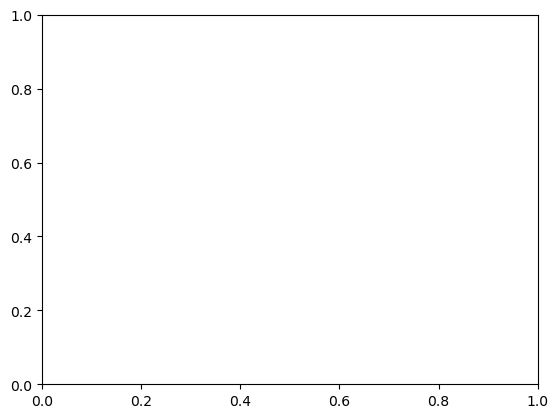

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import gym
import matplotlib.pyplot as plt

# Define the Q-network using PyTorch
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        # Increase the size of the first hidden layer
        self.fc1 = nn.Linear(state_size, 128)
        # Add a second hidden layer
        self.fc2 = nn.Linear(128, 128)
        # Add a third hidden layer
        self.fc3 = nn.Linear(128, 64)
        # Output layer
        self.fc4 = nn.Linear(64, action_size)

    def forward(self, x):
        # Apply activation function after each layer except the output layer
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # No activation function after the output layer
        return x
    
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # initial exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Check for GPU availability
        self.q_network = QNetwork(state_size, action_size).to(self.device)  # Move model to GPU
        self.target_network = QNetwork(state_size, action_size).to(self.device)  # Move model to GPU
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

        # Define the learning rate scheduler parameters
        scheduler_step_size = 100  # Define how often to update the learning rate
        scheduler_gamma = 0.9      # Define the decay rate of the learning rate

        # Initialize the learning rate scheduler
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).to(self.device)
        q_values = self.q_network(state)
        return q_values.argmax().item()

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)
        states = torch.FloatTensor(np.array(states)).to(self.device)  # Convert to single numpy ndarray
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)  # Convert to single numpy ndarray
        dones = torch.FloatTensor(dones).to(self.device)

        q_values = self.q_network(states)
        q_values_next = self.target_network(next_states).max(1)[0].unsqueeze(1)
        q_targets = rewards + (1 - dones) * self.gamma * q_values_next

        loss = self.criterion(q_values.gather(1, actions.unsqueeze(1)), q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.scheduler.step()
    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# Assuming your environment is named 'BallSortCraneEnv'
env = BallSortCraneEnv()
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
#agent.q_network.load_state_dict(torch.load('dqn_model.pth'))  # Load the trained model

EPISODES = 5000000  # or your preferred number of episodes
MAX_STEPS = 50  # or your preferred steps per episode
batch_size = 16  # or your preferred batch size
total_rewards = []
average_losses = []

for e in range(EPISODES):
    state = env.reset()
    total_reward = 0

    for time in range(MAX_STEPS):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        agent.remember(state, action, reward, next_state, done)
        state = next_state

        # Perform the replay
        agent.replay(batch_size)

        # Update target network periodically
        if time % 20 == 0:
            agent.update_target_network()

    total_rewards.append(total_reward)
    agent.decay_epsilon()  # Decay exploration rate over time
    print(f"Episode: {e+1}/{EPISODES}, Total Reward: {total_reward}")
    
    # Check if it's time to save the model
    if (e + 1) % 100 == 0:
        # Save the Q-network state_dict to a file
        torch.save(agent.q_network.state_dict(), f'dqn_model.pth')
        print(f"Saved model at episode {e + 1}")
        
# Plot the rewards
plt.plot(total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training Performance')
plt.show()


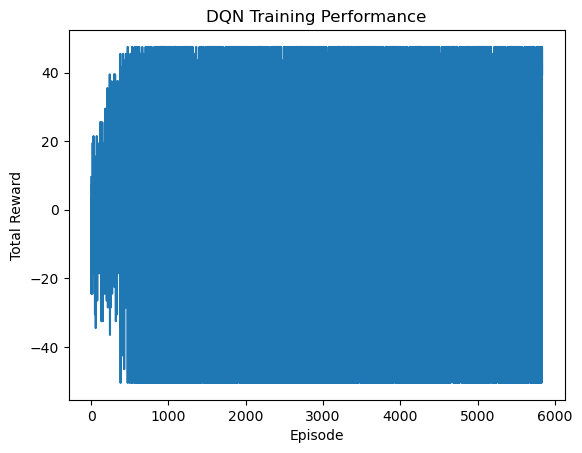

In [4]:
# Plot the rewards
plt.plot(total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training Performance')
plt.show()